# Convolutional Neural Networks

This tutorial borrows heavily from the following tutorials:

https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html

https://github.com/pytorch/examples/blob/main/mnist

More information on the syntax of putting together models in pytorch, including how to declare each of the layer types, can be found here:

https://pytorch.org/tutorials/beginner/introyt/modelsyt_tutorial.html

A lot of the instructional material at the beginning of the notebook is from here:

https://cs231n.github.io/convolutional-networks/

<hr style="border:2px solid gray">

## Index: <a id='index'></a>
1. [What is a CNN?](#CNN)
1. [Convolution](#Convolutions)
1. [Features of Convolutional Neural Networks](#FCNN)
1. [Stopping the growth, stride and pooling](#SGSP)
1. [Building and Training an Image Classifier](#BTIC)
1. [Train the Network](#TN)
1. [Test the Network on the Test Data](#TNTD)
1. [GPU Training](#GPU)

## What is a CNN [^](#index)
<a id='CNN'></a>

Let's imagine using a conventional neural network to classify large images. To use all the information each pixel in our image would be an input variable to our model. For colour images we'd need to multiply that by 3 for the red, green and blue channels.

Calculate how many weights you had to train in the 512 neuron first layer of the network we looked at last time. As a reminder that network had 28x28 gray-scale images as its input. Now calculate how many weights you'd have to train for a 1920x1080 colour image with 512 fully connected neurons in its first layer:

In [139]:
#Calculate some big numbers

We are usually not looking for underlying behaviour with that many degrees of freedom so if you did manage to train that many parameters, you would likely overfit.

<hr style="border:2px solid gray">

### What's the solution?
We know that our pixels are likely to share structure with the pixels near them in the image. Let's use this and structure our model differently. 

Regular neural nets are made up of several successive fully connected hidden layers that take all of the neurons in the previous layer as their input. 


<img src="https://cs231n.github.io/assets/nn1/neural_net2.jpeg"/>

Convolutional neural networks are made up of **'volumes'**. These have **height** and **width** as you might expect from a 2D image. They also have **'depth'**. This depth is different from what we meant when we talked about the number of layers in a conventional neural network.

At the input layer this depth is often 3, to account for the fact that there are red, green and blue channels in the image.

<img src="https://cs231n.github.io/assets/cnn/cnn.jpeg" alt="Alternative text" />

Now we have our input organised into this volume, we need to know what we do to it to go to the next layer and learn something about our image.

<hr style="border:2px solid gray">

### **Convolutions** [^](#index)
<a id='Convolutions'></a>
The core operation of a convolutional neural network is the convolution. We can view our volume that we defined in the previous section as a 3D matrix. What convolutions do is to take that 3D matrix and combine it with another 3D matrix called a 'kernel'. A 2D example of convolution is shown below.

<img src="https://miro.medium.com/max/720/1*r13ZUdVTQwVuhDPmo3JKag.png" alt="From: https://towardsdatascience.com/convolutional-neural-networks-explained-9cc5188c4939" />

In simple terms, if your kernel has size NxN, it takes all of the pixels in an NxN grid around a point in your image and performs a weighted sum. You then move it one pixel over and take the same weighted sum, over and over again until you've done it to the whole image.

In a convolutional neural network, your weights that you must train are the entries in the kernel. 

Let's see what certain kernels do to images to see why this sort of operation might be useful.

To start we'll need to get some images to work with. We'll use pytorch's torchvision package to download an image from the Caltech 101 database of images.

<hr style="border:2px solid gray">


In [10]:
import torch
import torchvision
import torchvision.transforms as transforms


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    print(npimg)
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

kerneltestset = torchvision.datasets.Caltech101(root='./data', 
                                        download=True, transform=transform)

kerneltestloader = torch.utils.data.DataLoader(kerneltestset, batch_size=1,
                                          shuffle=True, num_workers=2)


131740031it [00:13, 9539415.88it/s] 


Extracting ./data/caltech101/101_ObjectCategories.tar.gz to ./data/caltech101


14028800it [00:01, 9298416.95it/s] 


Extracting ./data/caltech101/Annotations.tar to ./data/caltech101


In [12]:
import torch
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

#transform = transforms.Compose([transforms.ToTensor(), 
#                                transforms.Normalize((0.5,), (0.5,))])

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

kerneltestset = torchvision.datasets.Caltech101(root='./data', 
                                        download=True, transform=transform)

print(len(kerneltestset))
kerneltestloader = torch.utils.data.DataLoader(kerneltestset, batch_size=1,
                                          shuffle=True, num_workers=2)


kerneltestiter = iter(kerneltestloader)
images, labels = next(kerneltestiter)



Files already downloaded and verified
8677


Now let's run our image through some example convolutions. There's a good list of things to try here:
https://en.wikipedia.org/wiki/Kernel_(image_processing) and I'd also try a Sobel edge detection kernel

Input


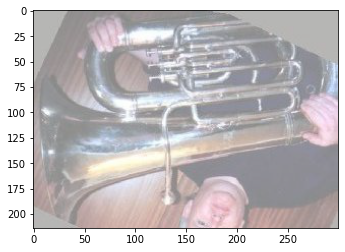

Output


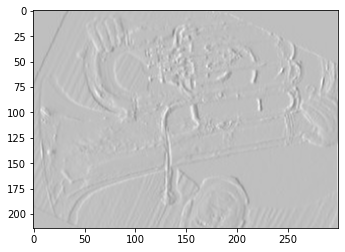

In [14]:
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np


nb_channels = 3

#The tensor here is the kernel we'll apply to the image

weights = torch.tensor([[-1., 0., 1.],
                        [-2., 0., 2.],
                        [-1., 0., 1.]])


weights = weights.view(1, 1, 3, 3).repeat(1, nb_channels, 1, 1)

conv = nn.Conv2d(3, 1,3,1,bias=False,padding=1)
conv.weight=torch.nn.Parameter(weights)

output = conv(images)

print("Input")
imshow(torchvision.utils.make_grid(images, normalize=True, nrow=3))
print("Output")
imshow(torchvision.utils.make_grid(output, normalize=True,nrow=3))

<hr style="border:2px solid gray">

## Features of convolutional neural networks [^](#index)
<a id='FCNN'></a>

### Translational invariance
One important aspect of convolutions is that they're 'translationally invariant'. Because the kernel only ever acts locally on one part of the image, it doesn't care where in the image a particular pattern is located. i.e. If the picture above was shifted 10 pixels to the right, you'd still get the same output, just also shifted 10 pixels to the right. That means if you find a kernel that is good at identifying a particular feature, it will find that feature wherever it is in the image.

### It's still a neural network
Convolutional neural networks are still neural networks so you still have to put an activation function after each layer to make sure the result couldn't just be simplified into a linear transformation

### The output of each layer can be much larger than the one before
If you have a single kernel then you end up with a volume the same size as the one you started. However, you can also have several kernels per layer in which case your volume grows by a factor of the number of kernels you use.

In the image above of our volume, you can see that the second layer has a much bigger depth than the first, and this is exactly because one usually has several kernels per layer. Next we'll look at how to deal with this.

<hr style="border:2px solid gray">

## Stopping the growth, stride and pooling [^](#index)
<a id='SGSP'></a>
We started off with CNNs because we didn't want a huge number of variables in our layers. However, we see above that our CNN will grow by a factor of the number of kernels we use every layer. If we used 10 kernels and had a 5 layer network this would be a very large increase in size by the final layer. We also eventually need to reduce the size of our network down to our desired output.

There are three main ways to do this:
* Have a standard 'fully connected' neural network layer at the end of the model
* Increase the 'stride'
* Use 'pooling'

The first option has exactly the same problems we were trying to get away from to start with, so we'll need to try something else first.

### Stride
Instead of moving your kernel across the image one pixel at a time, you move N pixels at a time. This results in the height and width of your output volume being a factor of N smaller. However, if the stride is too big you could miss features

### Pooling
Instead of changing how you do the convolution, pooling takes the output from a layer of the network and processes the volume to reduce its size before passing it onto the next layer. Typically this works by splitting the image up into small blocks or 'pools' and performing a mathematical operation on each pool that results in a single number.

The most common pooling is 'max pooling' where you just take the largest value in the pool, as shown below:

<img src="https://cs231n.github.io/assets/cnn/maxpool.jpeg"/>

This method has the advantage that if your kernel has found a very localised feature, you won't dilute its response to that feature.

Other options are 'average pooling' where you just take the mean, but this is less favoured as max pooling generally gives better results.


<hr style="border:2px solid gray">

## Building and Training an Image Classifier [^](#index)
<a id='BTIC'></a>

Let's put all of this together into a model. We'll use the CIFAR10 dataset which has smaller images than the Caltech101 set that we used above. We will do the following steps in order:

1. Load and normalize some the training and test datasets from the CIFAR10 repository using
   ``torchvision``
2. Define a Convolutional Neural Network
3. Define a loss function
4. Train the network on the training data
5. Test the network on the test data

### 1. Load and normalize CIFAR10

Generally, when you have to deal with image, text, audio or video data,
you can use standard python packages that load data into a numpy array.
Then you can convert this array into a ``torch.*Tensor``.

Specifically for vision, pytorch has a package called
``torchvision``, that has data loaders for common datasets such as
ImageNet, CIFAR10, MNIST, etc. and data transformers for images, e.g.,
``torchvision.datasets`` and ``torch.utils.data.DataLoader``. This avoids writing boilerplate code.

For this tutorial, we will use the CIFAR10 dataset.
It has the classes: ‘airplane’, ‘automobile’, ‘bird’, ‘cat’, ‘deer’,
‘dog’, ‘frog’, ‘horse’, ‘ship’, ‘truck’. The images in CIFAR-10 are of
size 3x32x32, i.e. 3-channel color images of 32x32 pixels in size.

In [16]:
import torch
import torchvision
import torchvision.transforms as transforms

The output of torchvision datasets are PILImage images of range [0, 1].
We should transform them to Tensors of normalized range [-1, 1].

We've put the training set and its loader in for you. Add the test set below:

In [17]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 4

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

100%|██████████| 170498071/170498071 [00:20<00:00, 8439811.70it/s] 


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


Plot some of the training images (remember that you applied normalisation to the original images that will need undoing):

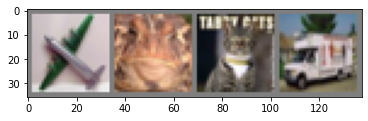

plane frog  cat   truck


In [18]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

### 2. Define a Convolutional Neural Network
Define a convolutional neural network for 3-channel images that has two convolution layers, separated by a 2x2 max pooling layer, then three fully connected linear layers. Your first layer should have an output size of 6 and use 5x5 kernels. The second layer should have 16 output channels and also use 5x5 kernels. The linear layers should have output sizes of 120, 84 and 10 respectively.

All layers should use a relu activation function

In [19]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()

### 3. Define a Loss function and optimizer
Let's use a Classification Cross-Entropy loss and SGD with momentum.



In [20]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

### 4. Train the Network [^](#index)
<a id='TN'></a>

Write the training loop for your network:


In [21]:
for epoch in range(2):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
            running_loss = 0.0

print('Finished Training')

[1,  2000] loss: 2.198
[1,  4000] loss: 1.841
[1,  6000] loss: 1.673
[1,  8000] loss: 1.592
[1, 10000] loss: 1.513
[1, 12000] loss: 1.493
[2,  2000] loss: 1.406
[2,  4000] loss: 1.388
[2,  6000] loss: 1.349
[2,  8000] loss: 1.342
[2, 10000] loss: 1.317
[2, 12000] loss: 1.308
Finished Training


Let's quickly save our trained model:



In [10]:
PATH = './cifar_net.pth'
torch.save(net.state_dict(), PATH)

See [here](https://pytorch.org/docs/stable/notes/serialization.html)
for more details on saving PyTorch models.

### 5. Test the Network on the Test Data [^](#index)
<a id='TNTD'></a>

We have trained the network for 2 passes over the training dataset.
But we need to check if the network has learnt anything at all.

We will check this by predicting the class label that the neural network
outputs, and checking it against the ground-truth. If the prediction is
correct, we add the sample to the list of correct predictions.

Okay, first step. Let us display an image from the test set to get familiar.



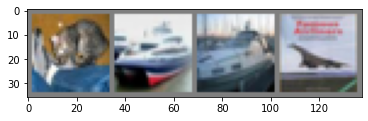

GroundTruth:  cat   ship  ship  plane


In [11]:
dataiter = iter(testloader)
images, labels = next(dataiter)

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join(f'{classes[labels[j]]:5s}' for j in range(4)))

Next, let's load back in our saved model (note: saving and re-loading the model
wasn't necessary here, we only did it to illustrate how to do so):



In [12]:
net = Net()
net.load_state_dict(torch.load(PATH))

<All keys matched successfully>

Okay, now let us see what the neural network thinks these examples above are:



In [13]:
outputs = net(images)

The outputs are energies for the 10 classes.
The higher the energy for a class, the more the network
thinks that the image is of the particular class.
So, let's get the index of the highest energy:



In [14]:
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join(f'{classes[predicted[j]]:5s}'
                              for j in range(4)))

Predicted:  cat   ship  ship  plane


The results seem pretty good.

Now write a function to see how the network performed on the full dataset


In [15]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in testloader:
        images, labels = data
        # calculate outputs by running images through the network
        outputs = net(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')

Accuracy of the network on the 10000 test images: 55 %


That looks way better than chance, which is 10% accuracy (randomly picking
a class out of 10 classes).
Seems like the network learnt something.

Let's write a test to see what are the classes that performed well, and the classes that did
not perform well:



In [16]:
# prepare to count predictions for each class
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

# again no gradients needed
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1


# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

Accuracy for class: plane is 71.6 %
Accuracy for class: car   is 64.2 %
Accuracy for class: bird  is 35.3 %
Accuracy for class: cat   is 18.9 %
Accuracy for class: deer  is 45.5 %
Accuracy for class: dog   is 48.1 %
Accuracy for class: frog  is 83.2 %
Accuracy for class: horse is 67.3 %
Accuracy for class: ship  is 70.0 %
Accuracy for class: truck is 55.0 %


Okay, so what next?

Try adjusting the parameters of the network (number of layers, type of layers, max vs average pooling etc.) and see how it performs

In [ ]:
Your code here....

There's also a web browser based tool that lets you play around with some of the hyperparameters of a CNN model trained on the CIFAR-10 dataset here: https://cs.stanford.edu/people/karpathy/convnetjs/demo/cifar10.html

For information I've also included information below on training neural networks on GPUs
<hr style="border:2px solid gray">

## Training on GPU [^](#index)
<a id='GPU'></a>
Just like how you transfer a Tensor onto the GPU, you transfer the neural
net onto the GPU.

Let's first define our device as the first visible cuda device if we have
CUDA available:



In [17]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# Assuming that we are on a CUDA machine, this should print a CUDA device:

print(device)

cpu


The rest of this section assumes that ``device`` is a CUDA device.

Then these methods will recursively go over all modules and convert their
parameters and buffers to CUDA tensors:

.. code:: python

    net.to(device)


Remember that you will have to send the inputs and targets at every step
to the GPU too:

.. code:: python

        inputs, labels = data[0].to(device), data[1].to(device)

Why don't I notice MASSIVE speedup compared to CPU? Because your network
is really small.

**Exercise:** Try increasing the width of your network (argument 2 of
the first ``nn.Conv2d``, and argument 1 of the second ``nn.Conv2d`` –
they need to be the same number), see what kind of speedup you get.

**Goals achieved**:

- Understanding PyTorch's Tensor library and neural networks at a high level.
- Train a small neural network to classify images

## Training on multiple GPUs
If you want to see even more MASSIVE speedup using all of your GPUs,
please check out :doc:`data_parallel_tutorial`.

## If you have a Mac with an arm processor
How to use the GPU/machine learning cores:
https://towardsdatascience.com/installing-pytorch-on-apple-m1-chip-with-gpu-acceleration-3351dc44d67c